**Import necessary modules**

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
from textblob import TextBlob
from tqdm import tqdm, trange

**Define some functions:**

In [3]:
# reduce dataframe memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df



# text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords

regex = re.compile('[^a-zA-Z]')
words = set(nltk.corpus.words.words())

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def text_process(text):
    np = text.lower().split('#coronaviruskenya') # Remove the hashtag
    np = ''.join(np)
    np = [word for word in np.split() if not word.startswith('@')] # remove mentions
    np = ' '.join(np)
    np = [c for c in np if c not in string.punctuation]
    np = [c for c in np if c != '\n'] # Removing newline
    np = ''.join(np)
    np = np.split('https')[0] # Remove links
    np = regex.sub(' ', np) # Remove emojis and any non-letters
    np = [word for word in np.split() if word not in stopwords.words('english')] # Remove stopwords
    np = [word for word in np if word in words or not word.isalpha()] # removal of non-english words
    np = [lemmatizer.lemmatize(word) for word in np] # lemmatization
    np =  ' '.join(np)
    #textblob spelling correction
    np = TextBlob(np)
    return str(np.correct())

Load the data

In [2]:
with open("csv files/COVID19_23_25July2021.csv", 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split("\t")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]

### Read csv
tweets = pd.read_csv("csv files/COVID19_23_25July2021.csv", header=None, delimiter="\t", names=column_names)
col_names = list(tweets.iloc[0])
tweets = pd.read_csv("csv files/COVID19_23_25July2021.csv", header=None, delimiter="\t", names=col_names)
tweets.drop(0, inplace=True); tweets.reset_index(drop=True, inplace=True)
tweets

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (0,1,5,6,15,16,17,21,23,25,26,27,28,29,30,32,33,34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1419307341560745985,1419307341560745985,2021-07-25 17:43:34 EAT,2021-07-25,17:43:34,+0300,931461115573178368,mohmoh_thaw,Moh Moh Thaw @ 玉娇,NaN,"Thailand confiscated more than 100,000 face ma...",en,[],[],['https://pbs.twimg.com/media/E7FM4JvVcAQvZ37....,0,0,0,"['whatshappeninginmyanmar', 'whatshappeningint...",[],https://twitter.com/MohMoh_Thaw/status/1419307...,False,NaN,1,https://pbs.twimg.com/media/E7FM4JvVcAQvZ37.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1419307340680114179,1419307340680114179,2021-07-25 17:43:34 EAT,2021-07-25,17:43:34,+0300,736004290532233216,washshine1,Wash&ShineMarketplac,NaN,From what I’m seeing it’s looking like a secon...,en,[],[],[],0,0,0,"['lockdown', 'b', 'devastating', 'deltavariant...",[],https://twitter.com/WASHSHINE1/status/14193073...,False,NaN,1,https://pbs.twimg.com/ext_tw_video_thumb/14193...,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1419307335982346240,1419210013839552514,2021-07-25 17:43:33 EAT,2021-07-25,17:43:33,+0300,3178688418,chris_f_carson,Christine Carson,NaN,@PitchfordMartin @ParksNursing Closing sentenc...,en,[],['https://abc.net.au/news/2021-07-25/nsw-recor...,[],0,0,0,['covid19'],[],https://twitter.com/Chris_F_Carson/status/1419...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'PitchfordMartin', 'name': 'm...",NaN,NaN,NaN,NaN
3,1419307331599339521,1419307331599339521,2021-07-25 17:43:31 EAT,2021-07-25,17:43:31,+0300,718026989664395264,interstateduane,Duane Bailey,NaN,With the more contagious #COVID19 delta varian...,en,"[{'screen_name': 'washingtonpost', 'name': 'th...",['https://wapo.st/3iDTrBq'],['https://pbs.twimg.com/media/E7Jj-WzXoAYdVwm....,0,0,0,"['covid19', 'federalgovernment', 'workplace', ...",[],https://twitter.com/InterstateDuane/status/141...,False,NaN,1,https://pbs.twimg.com/media/E7Jj-WzXoAYdVwm.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1419307331590963203,1419306851410358277,2021-07-25 17:43:31 EAT,2021-07-25,17:43:31,+0300,1001332699058114561,alejandranava_s,Alejandra Navarro S.,NaN,@Gu2Perez @FloryCantoX @cse_nicaragua @superfr...,es,[],[],[],0,0,0,"['24y25verificandonosganamostodos', 'somos2fsl...",[],https://twitter.com/alejandranava_s/status/141...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Gu2Perez', 'name': 'JaviNica...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133110,1418299486733062145,1418299486733062145,2021-07-22 22:58:43 EAT,2021-07-22,22:58:43,300,2596383959,vmax_14,veronica 🐦,NaN,#FreedomDay promo video for Saturday...as all ...,en,[],[],[],9,8,22,"['freedomday', 'farright', 'covid19']",[],https://twitter.com/vmax_14/status/14182994867...,False,NaN,1,https://pbs.twimg.com/ext_tw_video_thumb/14182...,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
133111,1418299483771842561,1418299483771842561,2021-07-22 22:58:42 EAT,2021-07-22,22:58:42,300,879646125208285185,jwieczorekpl,Wojewoda Śląski 🇵🇱 #ŚLĄSKIE,NaN,RAPORT WOJEWÓDZKI Sytuacja epidemiologiczna | ...,pl,[],[],['https://pbs.twimg.com/media/E67P2rAXMAEtkgN....,0,1,2,"['covid19', 'ministerstwozdrowia', 'śląskie', ...",[],https://twitter.com/JWieczorekPL/status/141829...,False,NaN,1,https://pbs.twimg.com/media/E67P2rAXMAEtkgN.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
133112,1418299473743294469,1418277916467625984,2021-07-22 22:58:39 EAT,2021-07-22,22:58:39,300,386543721,johnreichardwes,johnrwest,NaN,@nowthisnews Congress has Art 1 Sect 8 duties ...,en,[],[],[],0,0,0,"['covid19', 'covid19']",[],https://twitter.com/johnreichardwes/status/141...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'nowthisnews', 'name': 'Now

In [3]:
with open("csv files/COVID19_29_30March2020.csv", 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split("\t")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]

### Read csv
tweets_2 = pd.read_csv("csv files/COVID19_29_30March2020.csv", header=None, delimiter="\t", names=column_names)
col_names = list(tweets_2.iloc[0])
tweets_2 = pd.read_csv("csv files/COVID19_29_30March2020.csv", header=None, delimiter="\t", names=col_names)
tweets_2.drop(0, inplace=True); tweets_2.reset_index(drop=True, inplace=True)
tweets_2

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (0,1,5,6,15,16,17,21,23,25,26,27,28,29,30,32,33,34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1244414030011400192,1244414030011400192,2020-03-30 02:59:59 EAT,2020-03-30,02:59:59,+0300,81191957,calcharters,CA Charter Schools Association 👨🏻‍🎓👩🏾‍🎓,NaN,"For many students in our state, #COVID19 closu...",en,[],['https://hubs.ly/H0n_kGb0'],[],0,1,6,['covid19'],[],https://twitter.com/CALcharters/status/1244414...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1244414029864603657,1244414029864603657,2020-03-30 02:59:59 EAT,2020-03-30,02:59:59,+0300,61206610,npquarterly,Nonprofit Quarterly,NaN,Will the #coronavirus pandemic of 2020 come to...,en,[],['https://bit.ly/2vSTjK3'],[],0,2,1,"['coronavirus', 'covid19']",[],https://twitter.com/npquarterly/status/1244414...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1244414029189148672,1244414029189148672,2020-03-30 02:59:59 EAT,2020-03-30,02:59:59,+0300,259814704,ksharizal,khairisharizal,NaN,Tahniah #xaffani #xaffanisrikandi semoga our f...,in,[],['https://m.facebook.com/story.php?story_fbid=...,['https://pbs.twimg.com/media/EUUL9XYVAAEHZo9....,0,0,0,"['xaffani', 'xaffanisrikandi', 'staystrong', '...",[],https://twitter.com/ksharizal/status/124441402...,False,NaN,1,https://pbs.twimg.com/media/EUUL9XYVAAEHZo9.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1244414028790681600,1244353702573608961,2020-03-30 02:59:59 EAT,2020-03-30,02:59:59,+0300,1187038010660941824,dkthroughmyeyes,David,NaN,@Mawza_B @turtlesntikis @TerriDa08359398 @phea...,en,[],[],[],0,0,2,[],[],https://twitter.com/DKthroughmyeyes/status/124...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'TerriDa08359398', 'name': 'T...",NaN,NaN,NaN,NaN
4,1244414027410763776,1244414027410763776,2020-03-30 02:59:58 EAT,2020-03-30,02:59:58,+0300,3308211060,pedralve,Geolidaytours,NaN,"Las cuentas alternas de los ""empresarios"" de l...",es,[],[],[],1,0,1,[],[],https://twitter.com/Pedralve/status/1244414027...,False,https://twitter.com/maxmontesco/status/1244381...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102294,1244314914824519681,1244314914824519681,2020-03-29 20:26:08 EAT,2020-03-29,20:26:08,300,1010231296524804096,claire77252697,clairescosmetics,NaN,"Our last supper, I am working in a hot zone an...",en,[],[],['https://pbs.twimg.com/media/EUSx0XCWsAAl4eY....,0,0,3,[],[],https://twitter.com/claire77252697/status/1244...,False,NaN,1,https://pbs.twimg.com/media/EUSx0XCWsAAl4eY.jpg,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
102295,1244314911074811914,1244314911074811914,2020-03-29 20:26:07 EAT,2020-03-29,20:26:07,300,932286856103890944,comraminumusawa,Comr Aminu Shuaibu Musawa,NaN,IMPORTANT ANNOUNCEMENT!!! 📢#COVID19Nigeria ...,en,[],['https://www.instagram.com/p/B-U2xNqD7qM/?igs...,[],0,0,1,"['covid19nigeria', 'covid19', 'covid19']",[],https://twitter.com/comraminumusawa/status/124...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
102296,1244314909833379841,1244314909833379841,2020-03-29 20:26:07 EAT,2020-03-29,20:26:07,300,797558783912382464,mpozogomez,Manuelpozo,NaN,Diario de un confinamiento (I) Lourdes Chorro ...,es,"[{'screen_name': 'wordpressdotcom', 'name': 'w...",['https://primaduroverales.wordpress.com/2020/...,[],0,3,4,"['coronavirus', 'covid19', 'literatura', 'libr...",[],https://twitter.com/mpozogomez/status/12443149...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
102297,1244314909828993024,1244314909828993024,2020-03-29 20:26:07 EAT,2020-03-29,20:26:07,300,3107801359,younastauqeer,Tauqeer Younas,NaN,@arysabirshakirr are us citizens 125000+ reall...,en,[],[],[],0,0,0,[],[],https://twitter.com/Youna

In [4]:
# select tweets in English only
tweets = tweets[tweets.language == 'en']
tweets_2 = tweets_2[tweets_2.language == 'en']

In [5]:
# concat dataframes
tweets = pd.concat([tweets, tweets_2])

In [6]:
# extract relevant columns
tweets = tweets[['id', 'tweet', 'created_at', 'likes_count']]
tweets.head()

,id,tweet,created_at,likes_count
0,1419307341560745985,"Thailand confiscated more than 100,000 face ma...",2021-07-25 17:43:34 EAT,0
1,1419307340680114179,From what I’m seeing it’s looking like a secon...,2021-07-25 17:43:34 EAT,0
2,1419307335982346240,@PitchfordMartin @ParksNursing Closing sentenc...,2021-07-25 17:43:33 EAT,0
3,1419307331599339521,With the more contagious #COVID19 delta varian...,2021-07-25 17:43:31 EAT,0
5,1419307315220475908,@JKato3333 @ParksNursing Closing sentence: Of ...,2021-07-25 17:43:28 EAT,0


In [7]:
# rename columns
tweets.columns = ['tweet_id', 'text', 'created_at', 'likes']
tweets.head()

,tweet_id,text,created_at,likes
0,1419307341560745985,"Thailand confiscated more than 100,000 face ma...",2021-07-25 17:43:34 EAT,0
1,1419307340680114179,From what I’m seeing it’s looking like a secon...,2021-07-25 17:43:34 EAT,0
2,1419307335982346240,@PitchfordMartin @ParksNursing Closing sentenc...,2021-07-25 17:43:33 EAT,0
3,1419307331599339521,With the more contagious #COVID19 delta varian...,2021-07-25 17:43:31 EAT,0
5,1419307315220475908,@JKato3333 @ParksNursing Closing sentence: Of ...,2021-07-25 17:43:28 EAT,0


Concat with older data:

In [8]:
df = pd.read_csv('csv files/covidKE tweets.csv')
df2 = pd.read_csv('csv files/tweets.csv')
tweets = pd.concat([tweets, df, df2])
tweets

,tweet_id,text,created_at,likes,text length,polarity
0,1419307341560745985,"Thailand confiscated more than 100,000 face ma...",2021-07-25 17:43:34 EAT,0,NaN,NaN
1,1419307340680114179,From what I’m seeing it’s looking like a secon...,2021-07-25 17:43:34 EAT,0,NaN,NaN
2,1419307335982346240,@PitchfordMartin @ParksNursing Closing sentenc...,2021-07-25 17:43:33 EAT,0,NaN,NaN
3,1419307331599339521,With the more contagious #COVID19 delta varian...,2021-07-25 17:43:31 EAT,0,NaN,NaN
5,1419307315220475908,@JKato3333 @ParksNursing Closing sentence: Of ...,2021-07-25 17:43:28 EAT,0,NaN,NaN
...,...,...,...,...,...,...
1185,1242064075405905921,emergency response team sent trace catholic pr...,2020-03-23 12:22:06,4,73.0,0.113636
1186,1242064012797530112,time put mandatory hate happening,2020-03-23 12:21:51,1,33.0,-0.800000
1187,1242063970632163329,people lose trust governing becomes face choice,2020-03-23 12:21:41,1,47.0,0.000000
1188,1242063856727396352,incompetent wont die,2020-03-23 12:21:14,2,20.0,-0.350000


In [9]:
# reset index
tweets.reset_index(drop=True, inplace=True)

In [10]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135479 entries, 0 to 135478
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   tweet_id     135479 non-null  object 
 1   text         135471 non-null  object 
 2   created_at   135479 non-null  object 
 3   likes        135479 non-null  object 
 4   text length  1190 non-null    float64
 5   polarity     1190 non-null    float64
dtypes: float64(2), object(4)
memory usage: 6.2+ MB


## Text Preprocessing

We remove any special characters, punctuations and stopwords from the tweets.

In [11]:
import re
import string
import nltk
from nltk.corpus import stopwords

Let's design a function for this task

In [17]:
regex = re.compile('[^a-zA-Z]')
words = set(nltk.corpus.words.words())

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def text_process(text):
    np = [word for word in text.split() if not word.startswith('#')]# text.lower().split('#coronaviruskenya') # Remove hashtags
    np = [word for word in np if not word.startswith('@')] # Remove mentions
    np = ' '.join(np)
    np = [c for c in np if c not in string.punctuation]
    np = [c for c in np if c != '\n'] # Removing newline
    np = ''.join(np)
    np = np.split('https')[0] # Remove links
    np = regex.sub(' ', np) # Remove emojis and any non-letters
    np = [word for word in np.split() if word not in stopwords.words('english')] # Remove stopwords
    np = [word for word in np if word in words or not word.isalpha()] # removal of non-english words
    np = [lemmatizer.lemmatize(word) for word in np] # lemmatization
    np =  ' '.join(np)
    #textblob spelling correction
    #np = TextBlob(np)
    return np# str(np.correct())

In [18]:
# Preview working of the function
tweets.text[4]

'@JKato3333 @ParksNursing Closing sentence: Of the 43 people in intensive care, 42 have not been vaccinated.  https://t.co/m5gjqnSou5  (The video is wrong)  #COVID19'

In [20]:
text_process(tweets.text[4])

'sentence people intensive care'

In [21]:
# Drop instances where text is null
tweets = tweets.dropna(subset=['text'])

In [22]:
# Apply function to the text column
# We will overwrite the text column (after testing the function on a single tweet)

tweets['text'] = tweets['text'].apply(text_process)

<ipython-input-22-73cfcee6e838>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['text'] = tweets['text'].apply(text_process)


In [23]:
tweets

,tweet_id,text,created_at,likes,text length,polarity
0,1419307341560745985,face bound border two The covid said hidden,2021-07-25 17:43:34 EAT,0,NaN,NaN
1,1419307340680114179,I seeing looking like second global going,2021-07-25 17:43:34 EAT,0,NaN,NaN
2,1419307335982346240,sentence people intensive care,2021-07-25 17:43:33 EAT,0,NaN,NaN
3,1419307331599339521,contagious delta variant surging across nation...,2021-07-25 17:43:31 EAT,0,NaN,NaN
4,1419307315220475908,sentence people intensive care,2021-07-25 17:43:28 EAT,0,NaN,NaN
...,...,...,...,...,...,...
135474,1242064075405905921,emergency response team sent trace catholic pr...,2020-03-23 12:22:06,4,73.0,0.113636
135475,1242064012797530112,time put mandatory hate happening,2020-03-23 12:21:51,1,33.0,-0.800000
135476,1242063970632163329,people lose trust governing becomes face choice,2020-03-23 12:21:41,1,47.0,0.000000
135477,1242063856727396352,incompetent wont die,2020-03-23 12:21:14,2,20.0,-0.350000


## Sentiment Analysis

An example to show how we get the sentiment score/polarity for a single tweet

In [24]:
TextBlob(tweets.text[0]).sentiment

Sentiment(polarity=-0.16666666666666666, subjectivity=0.3333333333333333)

In [25]:
TextBlob(tweets['text'][0]).sentiment.polarity

-0.16666666666666666

Let's add a numerical column relating to text; text length 

In [26]:
tweets['text length'] = tweets['text'].apply(len)

<ipython-input-26-0a0503da7baa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['text length'] = tweets['text'].apply(len)


In [27]:
tweets.head()

,tweet_id,text,created_at,likes,text length,polarity
0,1419307341560745985,face bound border two The covid said hidden,2021-07-25 17:43:34 EAT,0,43,NaN
1,1419307340680114179,I seeing looking like second global going,2021-07-25 17:43:34 EAT,0,41,NaN
2,1419307335982346240,sentence people intensive care,2021-07-25 17:43:33 EAT,0,30,NaN
3,1419307331599339521,contagious delta variant surging across nation...,2021-07-25 17:43:31 EAT,0,98,NaN
4,1419307315220475908,sentence people intensive care,2021-07-25 17:43:28 EAT,0,30,NaN


Now we design a function to apply to the text column to produce polarity for each tweet

In [28]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

We add a new column to the dataframe based off of tweet polarity

In [29]:
tweets['polarity'] = tweets['text'].apply(get_polarity)

<ipython-input-29-12fa506dbfa6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['polarity'] = tweets['text'].apply(get_polarity)


In [30]:
# Short form using lambda
##
#tweets['polarity'] = tweets['text'].apply(lambda text: TextBlob(text).sentiment.polarity)

In [31]:
tweets.sample(30)

,tweet_id,text,created_at,likes,text length,polarity
107954,1244351565902856193,I think time kakistocracy stopped blaming fail...,2020-03-29 22:51:46 EAT,5,54,-0.316667
31210,1418783585104842754,I think know virus many people flu,2021-07-24 07:02:21 EAT,1,34,0.500000
98842,1244364426591055874,people testing positive let country announceme...,2020-03-29 23:42:53 EAT,0,119,0.213636
108452,1244350752778121216,Net Net vaccine still year away ignorance asto...,2020-03-29 22:48:33 EAT,0,127,0.186667
112961,1244343344316256256,The coming response spread come surprise try u...,2020-03-29 22:19:06 EAT,22,105,-0.025000
16119,1419028478129844224,No,2021-07-24 23:15:28 EAT,0,2,0.000000
113302,1244342785517318144,sent saving fight I wish god help u whole world,2020-03-29 22:16:53 EAT,4,47,0.200000
75056,1244399537692835840,age first professional succumb,2020-03-30 02:02:24 EAT,0,30,0.175000
71377,1244404586955317250,A article read,2020-03-30 02:22:28 EAT,0,14,0.000000
64832,1418334159269888002,gifted thats version saying care I love,2021-07-23 01:16:29 EAT,2,39,0.500000


Tweets with lowest polarity(-1)

In [32]:
tweets[tweets['polarity'] == -1]

,tweet_id,text,created_at,likes,text length,polarity
563,1419300917191479299,going prevent nasty side effect virus learn,2021-07-25 17:18:02 EAT,0,43,-1.0
696,1419299345510318085,The selfishness display phase pandemic disgust...,2021-07-25 17:11:47 EAT,0,79,-1.0
954,1419296864923435018,role safety specialist seen one terrifying peo...,2021-07-25 17:01:56 EAT,1,74,-1.0
1202,1419294908536471552,horrible person I read tweet Naomi working tog...,2021-07-25 16:54:10 EAT,0,92,-1.0
1379,1419293194018246658,Canada could avoid worst th wave yet,2021-07-25 16:47:21 EAT,0,36,-1.0
...,...,...,...,...,...,...
134108,1242077721976545280,worst time cut,2020-03-23 13:16:20,0,14,-1.0
134159,1242074156281274383,say could soon worst hit covid pep talk incons...,2020-03-23 13:02:10,0,53,-1.0
134646,1242106974927573000,dont think worst time,2020-03-23 15:12:34,2,21,-1.0
134934,1242096205234085894,worst thing father mother brother sister u,2020-03-23 14:29:47,1,42,-1.0


Tweets with polarity 0

In [33]:
tweets[tweets['polarity'] == 0]

,tweet_id,text,created_at,likes,text length,polarity
1,1419307340680114179,I seeing looking like second global going,2021-07-25 17:43:34 EAT,0,41,0.0
2,1419307335982346240,sentence people intensive care,2021-07-25 17:43:33 EAT,0,30,0.0
3,1419307331599339521,contagious delta variant surging across nation...,2021-07-25 17:43:31 EAT,0,98,0.0
4,1419307315220475908,sentence people intensive care,2021-07-25 17:43:28 EAT,0,30,0.0
6,1419307260925419526,The made detect ever virus could found body sa...,2021-07-25 17:43:15 EAT,0,63,0.0
...,...,...,...,...,...,...
135470,1242064302816874502,inequality different would,2020-03-23 12:23:00,0,26,0.0
135471,1242064212895174662,death zimbabwe corona virus,2020-03-23 12:22:39,4,27,0.0
135472,1242064211800477697,three county came back trip put mandatory,2020-03-23 12:22:39,2,41,0.0
135473,1242064200840744960,graceful enough observe protocol stay matter u...,2020-03-23 12:22:36,2,65,0.0


Tweets with highest polarity(1)

In [34]:
tweets[tweets['polarity'] == 1]

,tweet_id,text,created_at,likes,text length,polarity
9,1419307217250136070,The best education web,2021-07-25 17:43:04 EAT,0,22,1.0
2363,1419283163465932811,skepticism perfectly,2021-07-25 16:07:29 EAT,2,20,1.0
2613,1419280998295035912,best violence unspent b relief money forest,2021-07-25 15:58:53 EAT,4,43,1.0
3312,1419272343310921731,Sunday The Howard morning perfect,2021-07-25 15:24:30 EAT,3,33,1.0
3342,1419271803688656897,give continue imposing sunk economy best like ...,2021-07-25 15:22:21 EAT,0,51,1.0
...,...,...,...,...,...,...
134154,1242074830842793985,probably best thing read today click link,2020-03-23 13:04:50,1,41,1.0
134165,1242073657297551370,create best shoe impression,2020-03-23 13:00:11,0,27,1.0
134526,1242112888082481153,best version crisis,2020-03-23 15:36:04,0,19,1.0
135344,1242074830842793985,probably best thing read today click link,2020-03-23 13:04:50,1,41,1.0


In [35]:
# It is evident that more than half of the obtained tweets have polarity 0

Tweets with negative polarity

In [36]:
tweets[tweets['polarity'] < 0]

,tweet_id,text,created_at,likes,text length,polarity
0,1419307341560745985,face bound border two The covid said hidden,2021-07-25 17:43:34 EAT,0,43,-0.166667
7,1419307227081441286,face bound border two The covid said hidden,2021-07-25 17:43:07 EAT,0,43,-0.166667
23,1419307069061091330,fake fraud minimum suspicious doctor fake covi...,2021-07-25 17:42:29 EAT,1,77,-0.433333
36,1419306885350580225,intelligence call failure common knowledge nee...,2021-07-25 17:41:45 EAT,0,118,-0.205556
39,1419306749379551237,face bound border two The covid said hidden,2021-07-25 17:41:13 EAT,0,43,-0.166667
...,...,...,...,...,...,...
135461,1242064801540591621,sad god bless u god u,2020-03-23 12:24:59,3,21,-0.500000
135463,1242064688533438464,poor way anaemic watching,2020-03-23 12:24:32,2,25,-0.400000
135475,1242064012797530112,time put mandatory hate happening,2020-03-23 12:21:51,1,33,-0.800000
135477,1242063856727396352,incompetent wont die,2020-03-23 12:21:14,2,20,-0.350000


Tweets with positive polarity

In [37]:
tweets[tweets['polarity'] > 0]

,tweet_id,text,created_at,likes,text length,polarity
5,1419307294395879424,old U Mya State successfully infection,2021-07-25 17:43:23 EAT,0,38,0.425000
9,1419307217250136070,The best education web,2021-07-25 17:43:04 EAT,0,22,1.000000
10,1419307204499460100,pandemic essential vital force qualified skill...,2021-07-25 17:43:01 EAT,0,74,0.200000
12,1419307201185865730,good hear strong data suffer The real people f...,2021-07-25 17:43:00 EAT,0,57,0.444444
14,1419307193686429696,John D history modern know America declared pa...,2021-07-25 17:42:59 EAT,0,52,0.200000
...,...,...,...,...,...,...
135457,1242064900278620160,go many please na k,2020-03-23 12:25:23,2,19,0.500000
135459,1242064847866662913,way taking win though,2020-03-23 12:25:10,1,21,0.800000
135462,1242064784163573760,dating sugar worth,2020-03-23 12:24:55,2,18,0.300000
135465,1242064663577272321,advice young looking sugar mummy,2020-03-23 12:24:26,1,32,0.100000


## Some EDA

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

**Distribution of polarity**

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='polarity'>

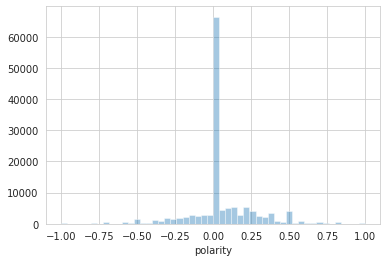

In [39]:
sns.distplot(tweets['polarity'], bins=50, kde=False)

**Distribution of text length**

<AxesSubplot:xlabel='text length'>

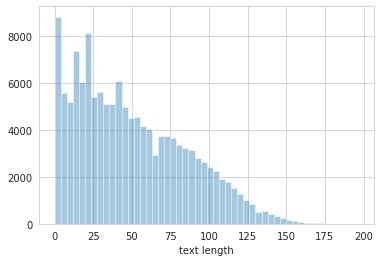

In [40]:
sns.distplot(tweets['text length'], kde=False)

A jointplot to show relation of text length and polarity

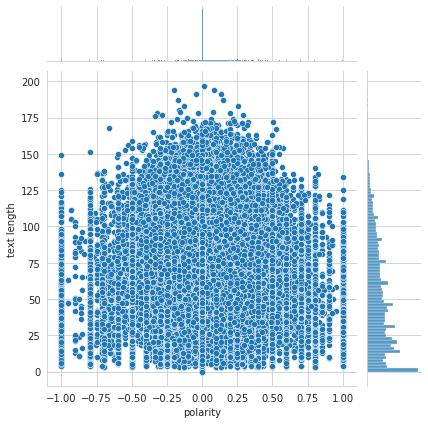

In [41]:
sns.jointplot(x='polarity', y='text length', data=tweets)

Most lengthy(range from 60 to 100) tweets range polarity from -0.25 and 0.25 from the jointplot above  
This is roughly around polarity 0, so we wouldn't be wrong to say that most lengthy tweets(in this range) have polarity of 0, or more appealing, around polarity 0  
Let's get the mean length of tweets with polarity 0 to see that indeed this length lies in this range(60 to 100)

In [42]:
tweets[tweets['polarity']==0]['text length'].mean()

31.12338814807834

To further visualize this fact, let's create the same plot but of hexagonal and regressional nature

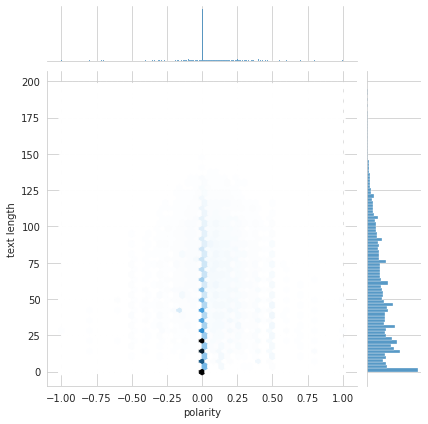

In [43]:
sns.jointplot(x='polarity', y='text length', data=tweets, kind='hex')

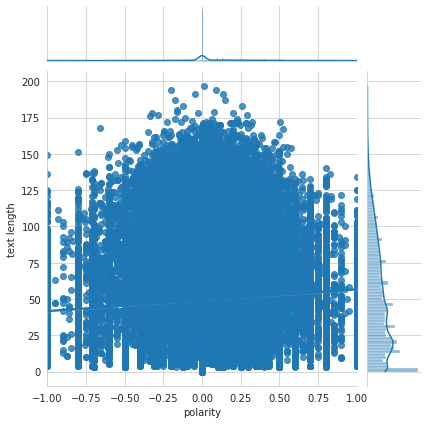

In [44]:
sns.jointplot(x='polarity', y='text length', data=tweets, kind='reg')

From this jointplot we can clearly see that the kde on the upper side of the plot shows some normal distribution around polarity 0  
This justifies our above argument that most lengthy(our range of 'lengthy') tweets have polarity of 0 (or around 0)

## **Adding external data**
### (16-02-2022)

In [3]:
# reread data
tweets = pd.read_csv("csv files/ALL_DATA.csv")
tweets

,tweet_id,text,created_at,likes,text length,polarity
0,1419307341560745985,face bound border two The covid said hidden,2021-07-25 17:43:34 EAT,0,43,-0.166667
1,1419307340680114179,I seeing looking like second global going,2021-07-25 17:43:34 EAT,0,41,0.000000
2,1419307335982346240,sentence people intensive care,2021-07-25 17:43:33 EAT,0,30,0.000000
3,1419307331599339521,contagious delta variant surging across nation...,2021-07-25 17:43:31 EAT,0,98,0.000000
4,1419307315220475908,sentence people intensive care,2021-07-25 17:43:28 EAT,0,30,0.000000
...,...,...,...,...,...,...
135466,1242064075405905921,emergency response team sent trace catholic pr...,2020-03-23 12:22:06,4,73,0.113636
135467,1242064012797530112,time put mandatory hate happening,2020-03-23 12:21:51,1,33,-0.800000
135468,1242063970632163329,people lose trust governing becomes face choice,2020-03-23 12:21:41,1,47,0.000000
135469,1242063856727396352,incompetent wont die,2020-03-23 12:21:14,2,20,-0.350000


In [19]:
# Let's classify sentiment as negative, neutral or positive
##
tweets['sentiment'] = np.nan

for i in trange(len(tweets)):
    if tweets['polarity'][i] < 0:
        tweets['sentiment'][i] = 'negative'
    elif tweets['polarity'][i] == 0:
        tweets['sentiment'][i] = 'neutral'
    else:
        tweets['sentiment'][i] = 'positive'
        
        
mapper = {
    'negative': -1,
    'neutral': 0,
    'positive': 1
}

tweets['target'] = tweets['sentiment'].map(mapper)

# Preview tweets
tweets.sample(15, random_state=101)

  0%|                                                                                                                                         | 0/135471 [00:00<?, ?it/s]/tmp/ipykernel_3415/4226720414.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['sentiment'][i] = 'negative'
/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_3415/4226720414.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

,tweet_id,text,created_at,likes,text length,polarity,sentiment,target
20124,1418965121389453319,way get people fired discus covid Those dont w...,2021-07-24 19:03:42 EAT,0,102,0.025000,positive,1
10479,1419139463255445505,fight vaccine,2021-07-25 06:36:29 EAT,12,13,0.000000,neutral,0
42404,1418601806519693315,NaN,2021-07-23 19:00:01 EAT,0,0,0.000000,neutral,0
92137,1244374882076377088,homeless people still shelter nowhere go theyr...,2020-03-30 00:24:25 EAT,40,116,-0.208333,negative,-1
60714,1418396013300121602,day average day day since get trapped politics...,2021-07-23 05:22:16 EAT,96,54,-0.175000,negative,-1
4397,1419255829644021764,improvement starting treatment due abnormal au...,2021-07-25 14:18:52 EAT,0,107,0.008333,positive,1
32588,1418756622214701062,browsing,2021-07-24 05:15:12 EAT,0,8,0.000000,neutral,0
90154,1244378255756365825,I deliver copy,2020-03-30 00:37:50 EAT,0,14,0.000000,neutral,0
2060,1419286160241692676,face bound border two The covid said hidden,2021-07-25 16:19:24 EAT,0,43,-0.166667,negative,-1
94584,1244370832073392129,decontamination two different achieve steriliz...,2020-03-30 00:08:20 EAT,0,138,-0.223810,negative,-1


In [25]:
# external data
ext_data1 = pd.read_csv("csv files/ext_data1.csv")
ext_data1

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know its getting tough when @KameronWilds...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [28]:
ext_data1.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [29]:
mapper = {
    'Neutral': 0,
    'Positive': 1,
    'Negative': -1,
    'Extremely Negative': -1,
    'Extremely Positive':1
}

ext_data1['target'] = ext_data1.Sentiment.map(mapper)

In [33]:
ext_data1.columns = ['UserName', 'ScreenName', 'Location', 'TweetAt', 'text',
       'Sentiment', 'target']

In [26]:
ext_data2 = pd.read_csv("csv files/ext_data2.csv")
ext_data2

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0
...,...,...,...
5282,train_6856,The spread of the novel among asylum seekers o...,1
5283,train_6857,Hundreds of Jewish patients are being treated...,1
5284,train_6858,Beats me Honestly most of the people I follow ...,0
5285,train_6859,Help us reach more people by donating and shar...,0


In [38]:
# combine datasets
ext_data = pd.concat([ext_data1, ext_data2]).dropna(subset=['text']).reset_index(drop=True)

In [39]:
ext_data.target.value_counts()

 1    20587
-1    15398
 0    10459
Name: target, dtype: int64

In [46]:
# preprocess external data
ext_data.text = ext_data.text.apply(text_process)

25min 6s ± 59.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
# combine tweets
all_data = pd.concat([tweets, ext_data])

In [49]:
all_data.target.value_counts()

 0    74128
 1    67814
-1    39973
Name: target, dtype: int64

In [50]:
# free memory
del ext_data1, ext_data2, tweets, ext_data

all_data = reduce_mem_usage(all_data)

Mem. usage decreased from 20.82 Mb to 14.40 Mb (30.8% reduction)


### (23-02-2022)

In [6]:
tweets = pd.read_csv("../data/ALL_DATA_V2.csv")
tweets.head(3)

/home/lyrax/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,tweet_id,text,created_at,likes,text length,polarity,sentiment,target,UserName,ScreenName,Location,TweetAt,Sentiment,ID
0,1.419307e+18,face bound border two The covid said hidden,2021-07-25 17:43:34 EAT,0.0,43.0,-0.1666,negative,-1,NaN,NaN,NaN,NaN,NaN,NaN
1,1.419307e+18,I seeing looking like second global going,2021-07-25 17:43:34 EAT,0.0,41.0,0.0000,neutral,0,NaN,NaN,NaN,NaN,NaN,NaN
2,1.419307e+18,sentence people intensive care,2021-07-25 17:43:33 EAT,0.0,30.0,0.0000,neutral,0,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
positive_df = pd.DataFrame()

for l in open("../data/positive-words.txt").readlines()[37:]:
    positive_df = positive_df.append({
        'text': l.strip(),
        'target': 1
    }, ignore_index=True)
    
positive_df

,target,text
0,1.0,abounds
1,1.0,abundance
2,1.0,abundant
3,1.0,accessable
4,1.0,accessible
...,...,...
1999,1.0,youthful
2000,1.0,zeal
2001,1.0,zenith
2002,1.0,zest


In [17]:
negative_df = pd.DataFrame()

for l in open("../data/negative-words.txt").readlines()[38:]:
    negative_df = negative_df.append({
        'text': l.strip(),
        'target': 1
    }, ignore_index=True)
    
negative_df

,target,text
0,1.0,abolish
1,1.0,abominable
2,1.0,abominably
3,1.0,abominate
4,1.0,abomination
...,...,...
4775,1.0,zaps
4776,1.0,zealot
4777,1.0,zealous
4778,1.0,zealously


In [20]:
# combine dataframes
all_data = pd.concat([tweets, positive_df, negative_df], ignore_index=True)
all_data = reduce_mem_usage(all_data)

Mem. usage decreased from 20.16 Mb to 13.68 Mb (32.1% reduction)


In [22]:
# Saving th data for further use in the model building phase
##
all_data.to_csv("../data/ALL_DATA_V3.csv", index=False)

## Model Building

See the [other](https://github.com/lyraxvincent/sentiment-analysis/blob/master/sentiment%20classifier%20modeling.ipynb) notebook in this project folder for the model building phase.